# Bot de inversion para cripto

In [1]:
#!pip install yfinance
#!pip install mpl_finance
#!pip install python-binance
#!pip3 install plotly

## import dependencies

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import datetime
from datetime import date
from datetime import timedelta
import plotly.graph_objects as go
from binance import Client
from config import API_Key,Secret_Key
import os
import glob

## Gathering data with binance api

In [3]:
client = Client(API_Key, Secret_Key)

In [4]:
# get historical kline data from any date range
#BTCOIN USDOLAR PRICE
#first currency and crypto,then time interval, and time to go back
# arguments of function have to be strings


def get_crypto_data(crypto, interval, lookback):
    Crypto_df = pd.DataFrame(client.get_historical_klines(crypto, interval, lookback + ' ago UTC'))
    
   # show only first 5 columns
    Crypto_df = Crypto_df.iloc[:,:6]
    #naming columns
    Crypto_df.columns = ['Date_and_Time','Open', 'High', 'Low','Last','Volume']
    # from the complete data, set index to date
#     Crypto_df = Crypto_df.\
#     set_index(pd.DatetimeIndex(Crypto_df['Date'].values))
#     Crypto_df.tail()
    Crypto_df = Crypto_df.set_index('Date_and_Time')
    Crypto_df.index = pd.to_datetime(Crypto_df.index, unit='ms')
#     Crypto_df.tz_localize('UTC').tz_convert('Mexico/General')
    

   # all values are stored as string so change them into float.
    Crypto_df = Crypto_df.astype(float)
    return Crypto_df

## Creating crypto df

In [5]:
crypto_df= get_crypto_data('BTCUSDT','1m','1 day').tz_localize('UTC').tz_convert('Mexico/General')
crypto_df.shape

(1440, 5)

In [6]:
crypto_df.tail(10)

,Open,High,Low,Last,Volume
Date_and_Time,,,,,
2021-11-21 21:17:00-06:00,57687.02,57736.27,57684.66,57712.83,17.19864
2021-11-21 21:18:00-06:00,57712.83,57763.39,57712.82,57761.86,10.36728
2021-11-21 21:19:00-06:00,57761.86,57803.23,57758.01,57759.90,17.99742
2021-11-21 21:20:00-06:00,57759.90,57759.91,57720.01,57739.16,11.02835
2021-11-21 21:21:00-06:00,57739.16,57739.64,57686.14,57700.01,24.07973
2021-11-21 21:22:00-06:00,57700.00,57719.07,57656.57,57676.46,16.36998
2021-11-21 21:23:00-06:00,57676.46,57682.75,57650.00,57663.26,13.78064
2021-11-21 21:24:00-06:00,57663.26,57664.11,57641.44,57642.71,12.59113
2021-11-21 21:25:00-06:00,57642.72,57718.70,57637.26,57686.16,16.23464


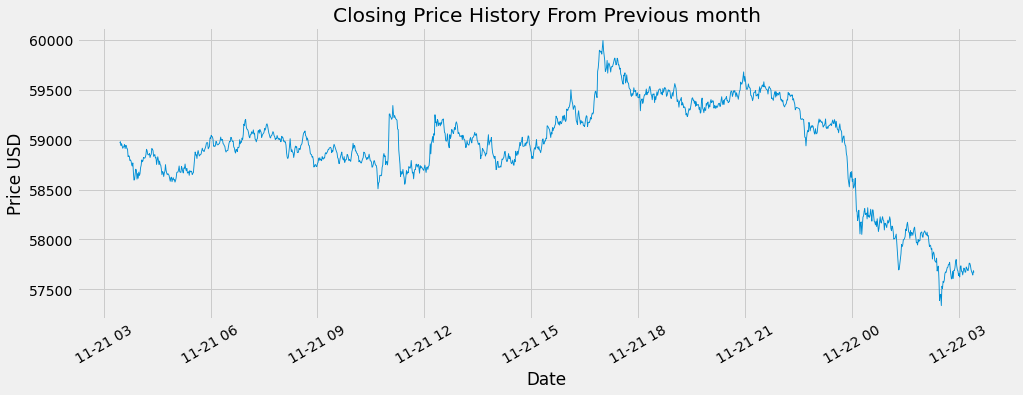

In [7]:
# plot prices
plt.figure(figsize=(15, 5))
plt.plot(crypto_df['Last'],label='closing price', linewidth = 0.9)
plt.title('Closing Price History From Previous month')
plt.xlabel('Date')
plt.ylabel('Price USD')
plt.xticks(rotation=30)
plt.show()

In [8]:
# fig = go.Figure(data=[go.Candlestick(x=crypto_df.index,
#                 open=crypto_df['Open'],
#                 high=crypto_df['High'],
#                 low=crypto_df['Low'],
#                 close=crypto_df['Last'])])
# fig.update_layout(xaxis_rangeslider_visible=False)
# fig.show()

## code machine larning: Linear regresion and tecnical indicators

In [9]:
# showing only BTC price
crypto_last_price_df = crypto_df[['Last']]
crypto_last_price_df.head(16)

,Last
Date_and_Time,
2021-11-20 21:27:00-06:00,58964.99
2021-11-20 21:28:00-06:00,58979.28
2021-11-20 21:29:00-06:00,58942.01
2021-11-20 21:30:00-06:00,58960.09
2021-11-20 21:31:00-06:00,58935.14
2021-11-20 21:32:00-06:00,58913.53
2021-11-20 21:33:00-06:00,58927.20
2021-11-20 21:34:00-06:00,58929.66
2021-11-20 21:35:00-06:00,58952.43


In [10]:
#  variable for predicting x number of periods into the future
predict_periods = 16 #numer of periods, then change this info to function

# create another column shifted n units up
crypto_last_price_df['Prediction'] = crypto_last_price_df[['Last']].shift(-predict_periods)

<ipython-input-10-91f82b2f9c00>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crypto_last_price_df['Prediction'] = crypto_last_price_df[['Last']].shift(-predict_periods)


In [11]:
# show df with new column
crypto_last_price_df.head(16)

,Last,Prediction
Date_and_Time,,
2021-11-20 21:27:00-06:00,58964.99,58835.29
2021-11-20 21:28:00-06:00,58979.28,58791.66
2021-11-20 21:29:00-06:00,58942.01,58796.32
2021-11-20 21:30:00-06:00,58960.09,58785.73
2021-11-20 21:31:00-06:00,58935.14,58750.01
2021-11-20 21:32:00-06:00,58913.53,58735.77
2021-11-20 21:33:00-06:00,58927.20,58766.95
2021-11-20 21:34:00-06:00,58929.66,58663.25
2021-11-20 21:35:00-06:00,58952.43,58594.10


In [12]:
# show last 15 rows of new dataset
crypto_last_price_df.tail(17)

,Last,Prediction
Date_and_Time,,
2021-11-21 21:10:00-06:00,57704.76,57668.86
2021-11-21 21:11:00-06:00,57671.86,NaN
2021-11-21 21:12:00-06:00,57672.02,NaN
2021-11-21 21:13:00-06:00,57723.96,NaN
2021-11-21 21:14:00-06:00,57711.01,NaN
2021-11-21 21:15:00-06:00,57694.70,NaN
2021-11-21 21:16:00-06:00,57687.03,NaN
2021-11-21 21:17:00-06:00,57712.83,NaN
2021-11-21 21:18:00-06:00,57761.86,NaN


In [13]:
# create independent dataset, convert the dataframe to a np array and drop prediction column
a=np.array(crypto_last_price_df[['Last']])
#remove the last n rows where n is the prediction days
a=a[:-predict_periods]
print(a)

[[58964.99]
 [58979.28]
 [58942.01]
 ...
 [57678.45]
 [57712.57]
 [57704.76]]


In [14]:
# CREATE THE DEPENDENT DATA SET
#CONVERT THE DF TO A NP ARRAY
b = crypto_last_price_df['Prediction'].values

#get all values except las n rows
b = b[:-predict_periods]
print(b)

[58835.29 58791.66 58796.32 ... 57642.71 57686.16 57668.86]


In [15]:
# split the data into 85% traning and 15% testing
a_train, a_test, b_train, b_test = train_test_split(a,b, test_size = 0.15, shuffle = False)

In [16]:
# create and train the model
Lreg = LinearRegression()
# train
Lreg.fit(a_train,b_train)


LinearRegression()

In [17]:
# test shows R^2 
Lreg_similarity = Lreg.score(a_test,b_test)
print('LIN REG SIMILARITY:', Lreg_similarity)

LIN REG SIMILARITY: -0.22891277569284574


In [18]:
# create variable a_projection and set equal to last 14 rows of original dataset
a_projection = np.array(crypto_last_price_df[['Last']])[-predict_periods:]
print(a_projection)

[[57671.86]
 [57672.02]
 [57723.96]
 [57711.01]
 [57694.7 ]
 [57687.03]
 [57712.83]
 [57761.86]
 [57759.9 ]
 [57739.16]
 [57700.01]
 [57676.46]
 [57663.26]
 [57642.71]
 [57686.16]
 [57668.86]]


In [19]:
# print lreg models predictions for next 14 days
Lreg_predict = Lreg.predict(a_projection)
print(Lreg_predict)

[57888.27612825 57888.4118379  57932.46658322 57921.48258338
 57907.64868087 57901.1430995  57923.02628065 57964.6128067
 57962.95036348 57945.35900002 57912.1525449  57892.17778071
 57880.98173453 57863.55152629 57900.40517827 57885.7315723 ]


In [30]:
results_compare=zip(a_projection,Lreg_predict)
results_df= pd.DataFrame(results_compare, columns = ['actual_price', 'predicted_price'])

previously_predicted = results_df[['predicted_price']]

date = datetime.now().strftime("%Y_%m_%d_%I_%M_%S_%p")
previously_predicted.to_csv(f'Resources/previous_predicted_price_{date}.csv') 

pwd = os.getcwd()
path = os.path.join(pwd,'Resources')
entries = os.listdir(path)

price_results_df = pd.concat([results_df, pd.read_csv('Resources/'+ entries[-2])], axis =1)
price_results_df.drop(columns=['Unnamed: 0'],inplace=True, axis=1)
price_results_df.columns = ['actual_price', 'predicted_price', 
                                            'previously_predicted_price']
price_results_df.head(17)

['.ipynb_checkpoints', 'previous_predicted_price_2021_11_21_09_24_57_PM.csv', 'previous_predicted_price_2021_11_21_09_26_51_PM.csv']
previous_predicted_price_2021_11_21_09_24_57_PM.csv


,actual_price,predicted_price,previously_predicted_price
0,[57671.86],57888.276128,57922.401425
1,[57672.02],57888.411838,57915.773269
2,[57723.96],57932.466583,57887.851841
3,[57711.01],57921.482583,57887.987629
4,[57694.7],57907.648681,57932.067840


In [21]:
results_df.describe()

,predicted_price
count,16.000000
mean,57910.648606
std,29.281234
min,57863.551526
25%,57888.377910
50%,57904.395890
75%,57925.386356
max,57964.612807


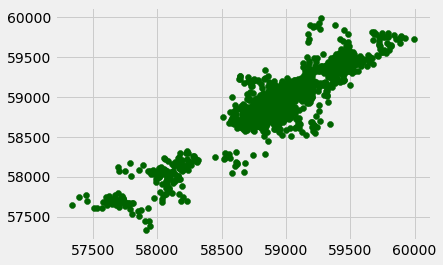

In [22]:
plt.scatter(a, b, color="DarkGreen" )

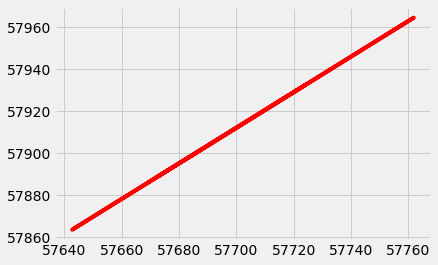

In [23]:
plt.plot(a_projection,Lreg_predict, color='r')

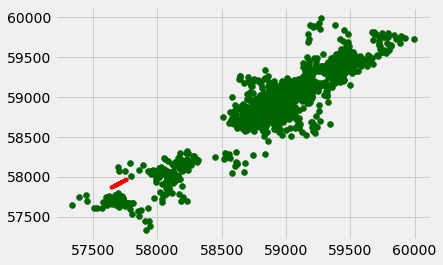

In [24]:
plt.scatter(a, b, color="DarkGreen" )
plt.plot(a_projection,Lreg_predict, color='r')
plt.show()

## TI MACHINE L GRAPAHS

In [25]:
def TI_MachLearn_graphs(df):
    #Create DF for MACD
    crypto_MACD_df= df.copy(deep=True)
    #Calculate MACD and signal line 
    # short term EMA ewm=exponential weighted functions
    crypto_MACD_df['S_EMA']=crypto_MACD_df.predicted_price.ewm(span=12, adjust=False).mean()
    #Long term EMA ewm=exponential weighted functions
    crypto_MACD_df['L_EMA']=crypto_MACD_df.predicted_price.ewm(span=26, adjust=False).mean()
    #Calculate MACD line
    crypto_MACD_df['MACD_line']=\
                              crypto_MACD_df.S_EMA-crypto_MACD_df.L_EMA
    #calculate Signal Line
    crypto_MACD_df['Sig_line']=\
                              crypto_MACD_df.MACD_line.ewm(span=9, adjust=False).mean()
    
    #chart from previous week
    plt.figure(figsize=(12, 5))
    plt.plot(crypto_MACD_df.MACD_line, label='BTC MACD', color='k')
    plt.plot(crypto_MACD_df.Sig_line, label='signal ln', color='r')
    plt.title('MACD graph next 16 periods')
    plt.xlabel('Date')
    plt.ylabel('PRICE USD')
    plt.xticks(rotation=30)
    plt.legend(loc='upper left')

   ####################################################################################
    crypto_BBand_df=df.copy(deep=True)
    # calculate SMA, SD, UPPER BAN, LOWER BAND
    #GET TIME PERIOD
    period = 2 

    # calculate SMA
    crypto_BBand_df['SMA']=crypto_BBand_df['predicted_price'].rolling(window = period).mean()
    #calculate std
    crypto_BBand_df['STD']=crypto_BBand_df['predicted_price'].rolling(window = period).std()
    #calculate BB UP
    crypto_BBand_df['BBand Upper']=crypto_BBand_df['SMA']+(crypto_BBand_df['STD']*2)
    #calculate BB LOW
    crypto_BBand_df['BBand Lower']=crypto_BBand_df['SMA']-(crypto_BBand_df['STD']*2)

    #list of colmns to keep
    column_ls = ['predicted_price','SMA', 'BBand Upper','BBand Lower']
    #plot data PREVIOUS WEEK
    fig = plt.figure(figsize = (13,6))
    ax=fig.add_subplot(1,1,1)
    x_axis=crypto_BBand_df.index
    ax.fill_between(x_axis,crypto_BBand_df['BBand Upper'], crypto_BBand_df['BBand Lower'],label='BBands', color='beige')
    ax.plot(x_axis,crypto_BBand_df['predicted_price'], color = 'k', label='closing price')
    ax.plot(x_axis,crypto_BBand_df['SMA'], color = 'r', label='SMA')
    ax.set_title('BBands next 16 periods')
    ax.set_xlabel('Date')
    ax.set_ylabel('price')
    plt.xticks(rotation=30)
    ax.legend()
    plt.show()    

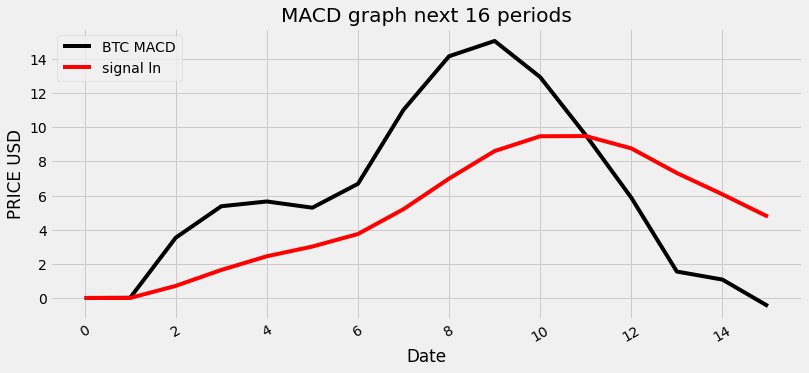

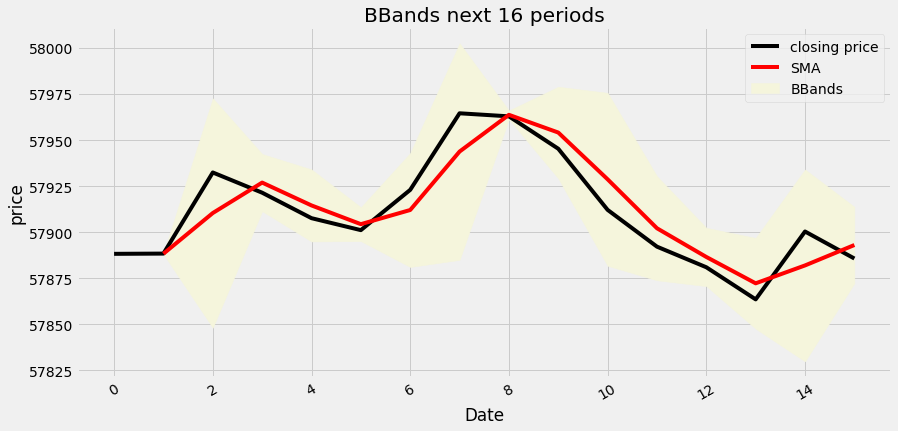

In [26]:
TI_MachLearn_graphs(results_df)

## macd machine learning notification

In [27]:
#buy sell signal
def alert_MACD_ML(signal):
    buy = []
#     crypto_buy_price = []
#     crypto_sell_price = []
    sell = []
    flag = -1
    for i in range(0,len(signal)):
        if signal['MACD_line'][i] > signal['Sig_line'][i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append('1')
                crypto_buy_price.append(signal['predicted_price'][i])
                flag = 1
            else:
                buy.append(np.nan)
        elif signal['MACD_line'][i] < signal['Sig_line'][i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append('1')
                crypto_sell_price.append(signal['predicted_price'][i])
                flag = 0
            else:
                sell.append(np.nan)
                crypto_sell_price.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    return(buy,sell)
            

In [28]:
#Create DF for MACD
crypto_MACD_ML_df= results_df.copy(deep=True)
#Calculate MACD and signal line 
# short term EMA ewm=exponential weighted functions
crypto_MACD_ML_df['S_EMA']=crypto_MACD_ML_df.predicted_price.ewm(span=12, adjust=False).mean()
#Long term EMA ewm=exponential weighted functions
crypto_MACD_ML_df['L_EMA']=crypto_MACD_ML_df.predicted_price.ewm(span=26, adjust=False).mean()
#Calculate MACD line
crypto_MACD_ML_df['MACD_line']=\
                          crypto_MACD_ML_df.S_EMA-crypto_MACD_ML_df.L_EMA
#calculate Signal Line
crypto_MACD_ML_df['Sig_line']=\
                          crypto_MACD_ML_df.MACD_line.ewm(span=9, adjust=False).mean()
crypto_MACD_ML_df.tail(20)

,actual_price,predicted_price,S_EMA,L_EMA,MACD_line,Sig_line
0,[57671.86],57888.276128,57888.276128,57888.276128,0.000000,0.000000
1,[57672.02],57888.411838,57888.297007,57888.286181,0.010826,0.002165
2,[57723.96],57932.466583,57895.092326,57891.558803,3.533523,0.708437
3,[57711.01],57921.482583,57899.152366,57893.775380,5.376986,1.642147
4,[57694.7],57907.648681,57900.459491,57894.803031,5.656460,2.445009
5,[57687.03],57901.143099,57900.564662,57895.272666,5.291995,3.014406
6,[57712.83],57923.026281,57904.020295,57897.328489,6.691806,3.749886
7,[57761.86],57964.612807,57913.342220,57902.312513,11.029707,5.205851
8,[57759.9],57962.950363,57920.974242,57906.804206,14.170037,6.998688
9,[57739.16],57945.359000,57924.725743,57909.660116,15.065627,8.612076


In [29]:
#create buy and sell columns in df
x = alert_MACD_ML(crypto_MACD_ML_df)
crypto_MACD_ML_df['Buy_Notification'] = x[0]
crypto_MACD_ML_df['Sell_Notification'] = x[1]
# crypto_MACD_ML_df['Crypto_buy_price'] = x[2]
# crypto_MACD_ML_df['Crypto_sell_price'] = x[3]

# create df with buy and sell info
crypto_MACD_ML_BuySell_Sig_df = crypto_MACD_ML_df[['Buy_Notification', 'Sell_Notification']]
crypto_MACD_ML_BuySell_Sig_df.fillna(0).head(50)

NameError: name 'crypto_buy_price' is not defined

In [ ]:
crypto_MACD_ML_BuySell_Sig_df.to_csv('predicted_notifications')

## MACD df

In [ ]:
#Create DF for MACD
crypto_MACD_df= crypto_df.copy(deep=True)
#Calculate MACD and signal line 
# short term EMA ewm=exponential weighted functions
crypto_MACD_df['S_EMA']=crypto_MACD_df.Last.ewm(span=12, adjust=False).mean()
#Long term EMA ewm=exponential weighted functions
crypto_MACD_df['L_EMA']=crypto_MACD_df.Last.ewm(span=26, adjust=False).mean()
#Calculate MACD line
crypto_MACD_df['MACD_line']=\
                          crypto_MACD_df.S_EMA-crypto_MACD_df.L_EMA
#calculate Signal Line
crypto_MACD_df['Sig_line']=\
                          crypto_MACD_df.MACD_line.ewm(span=9, adjust=False).mean()
crypto_MACD_df.tail(20)


## MACD buy and sell notification

In [ ]:
#buy sell signal
def alert_MACD(signal):
    buy = []
    sell = []
    flag = -1
    for i in range(0,len(signal)):
        if signal['MACD_line'][i] > signal['Sig_line'][i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append('1')
                flag = 1
            else:
                buy.append(np.nan)
        elif signal['MACD_line'][i] < signal['Sig_line'][i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append('1')
                flag = 0
            else:
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    return(buy,sell)
            

In [ ]:
#create buy and sell columns in df
x = alert_MACD(crypto_MACD_df)
crypto_MACD_df['Buy_Notification'] = x[0]
crypto_MACD_df['Sell_Notification'] = x[1]

# create df with buy and sell info
crypto_MACD_BuySell_Sig_df = crypto_MACD_df[['Buy_Notification', 'Sell_Notification']]
crypto_MACD_BuySell_Sig_df.fillna(0).sort_index(ascending=False).head(50)

## BOLLINGER BANDS df

In [ ]:
crypto_BBand_df =crypto_df.copy(deep=True)
# calculate SMA, SD, UPPER BAN, LOWER BAND
#GET TIME PERIOD
period = 20

# calculate SMA
crypto_BBand_df['SMA']=crypto_BBand_df['Last'].rolling(window = period).mean()
#calculate std
crypto_BBand_df['STD']=crypto_BBand_df['Last'].rolling(window = period).std()
#calculate BB UP
crypto_BBand_df['BBand Upper']=crypto_BBand_df['SMA']+(crypto_BBand_df['STD']*2)
#calculate BB LOW
crypto_BBand_df['BBand Lower']=crypto_BBand_df['SMA']-(crypto_BBand_df['STD']*2)

crypto_BBand_df.head(30)

## BBand buy sell Notification

In [ ]:
#buy sell signal
def alert_BBands(signal):
    buy = []
    sell = []
    flag = -1
    for i in range(0,len(signal)):
        if signal['Last'][i] > signal['BBand Upper'][i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append('1')
                flag = 1
            else:
                buy.append(np.nan)
        elif signal['Last'][i] < signal['BBand Lower'][i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append('1')
                flag = 0
            else:
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    return(buy,sell)
            

In [ ]:
#create buy and sell columns in df
x=alert_BBands(crypto_BBand_df)
crypto_BBand_df['Buy_Notification'] = x[0]
crypto_BBand_df['Sell_Notification'] = x[1]

# create df with buy and sell info
crypto_BBand_BuySell_Sig_df = crypto_BBand_df[['Buy_Notification', 'Sell_Notification']]
crypto_BBand_BuySell_Sig_df.fillna(0).sort_index(ascending=False).head(50)

## TI-Buy&Sell-notification(MACD & BBand alert condition is equal)

In [ ]:
def alert(df1,df2):
    buy = []
    sell = []
    flag = -1
    for i in range(0,len(df1)):
        if df1['Buy_Notification'][i] == df2['Buy_Notification'][i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append('1')
                flag = 1
            else:
                buy.append(np.nan)
        elif df1['Sell_Notification'][i]== df2['Sell_Notification'][i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append('1')
                flag = 0
            else:
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    return(buy,sell)               
            

In [ ]:
#create buy and sell columns in df
x=alert(crypto_BBand_df,crypto_MACD_df)
crypto_alert_df = crypto_df.copy(deep=True)
crypto_alert_df['Buy_Notification'] = x[0]
crypto_alert_df['Sell_Notification'] = x[1]

# create df with buy and sell info
crypto_alert_BuySell_Sig_df = crypto_alert_df[['Buy_Notification', 'Sell_Notification']]
crypto_alert_BuySell_Sig_df.fillna(0).sort_index(ascending=False).head(59)

In [ ]:
crypto_buy_df=crypto_alert_BuySell_Sig_df.loc[crypto_alert_BuySell_Sig_df['Buy_Notification'] == 1]
crypto_buy_df

In [ ]:
crypto_sell_df=crypto_alert_BuySell_Sig_df.loc[crypto_alert_BuySell_Sig_df['Sell_Notification'] == 1]
crypto_sell_df

In [ ]:
crypto_df['Last'].describe()

## Technical Indicators graphs

In [ ]:
def TI_graphs(df):
    #Create DF for MACD
    crypto_MACD_df= df.copy(deep=True)
    #Calculate MACD and signal line 
    # short term EMA ewm=exponential weighted functions
    crypto_MACD_df['S_EMA']=crypto_MACD_df.Last.ewm(span=12, adjust=False).mean()
    #Long term EMA ewm=exponential weighted functions
    crypto_MACD_df['L_EMA']=crypto_MACD_df.Last.ewm(span=26, adjust=False).mean()
    #Calculate MACD line
    crypto_MACD_df['MACD_line']=\
                              crypto_MACD_df.S_EMA-crypto_MACD_df.L_EMA
    #calculate Signal Line
    crypto_MACD_df['Sig_line']=\
                              crypto_MACD_df.MACD_line.ewm(span=9, adjust=False).mean()
    
    #chart from previous week
    plt.figure(figsize=(12, 5))
    plt.plot(crypto_MACD_df.MACD_line, label='BTC MACD', color='k',linewidth=0.7)
    plt.plot(crypto_MACD_df.Sig_line, label='signal ln', color='r', linewidth=1)
    plt.title('MACD graph from previous month')
    plt.xlabel('Date')
    plt.ylabel('PRICE USD')
    plt.xticks(rotation=30)
    plt.legend(loc='upper left')
    
    # plt chart from previous day 
    now = datetime.now()
    Previous_Date = date.today() - timedelta(days=1)
    plt.figure(figsize=(13, 4))
    plt.plot(crypto_MACD_df.MACD_line, label='BTC MACD', color='k',linewidth=0.9)
    plt.plot(crypto_MACD_df.Sig_line, label='signal ln', color='r',linewidth=0.7)
    plt.legend(loc='upper left')
    plt.xlim([Previous_Date, now])
    plt.title('MACD graph from previous day')
    plt.xlabel('Date')
    plt.ylabel('PRICE USD')
    plt.xticks(rotation=30)
    plt.show()
    
    # plt chart from previous hour
    now = datetime.now()
    lastHour = date.today() - timedelta(hours = 1)
    plt.figure(figsize=(15, 5))
    plt.plot(crypto_MACD_df.MACD_line, label='BTC MACD', color='k',linewidth=0.7)
    plt.plot(crypto_MACD_df.Sig_line, label='signal ln', color='r',linewidth=1)
    plt.legend(loc='upper left')
    plt.xlim([lastHour, now])
    plt.title('MACD graph from previous hour')
    plt.xlabel('Date')
    plt.ylabel('PRICE USD')
    plt.xticks(rotation=30)
    plt.show()
   ####################################################################################
    crypto_BBand_df=df.copy(deep=True)
    # calculate SMA, SD, UPPER BAN, LOWER BAND
    #GET TIME PERIOD
    period = 20 

    # calculate SMA
    crypto_BBand_df['SMA']=crypto_BBand_df['Last'].rolling(window = period).mean()
    #calculate std
    crypto_BBand_df['STD']=crypto_BBand_df['Last'].rolling(window = period).std()
    #calculate BB UP
    crypto_BBand_df['BBand Upper']=crypto_BBand_df['SMA']+(crypto_BBand_df['STD']*2)
    #calculate BB LOW
    crypto_BBand_df['BBand Lower']=crypto_BBand_df['SMA']-(crypto_BBand_df['STD']*2)

    #list of colmns to keep
    column_ls = ['Last','SMA', 'BBand Upper','BBand Lower']
    #plot data PREVIOUS WEEK
    fig = plt.figure(figsize = (13,6))
    ax=fig.add_subplot(1,1,1)
    x_axis=crypto_BBand_df.index
    ax.fill_between(x_axis,crypto_BBand_df['BBand Upper'], crypto_BBand_df['BBand Lower'],label='BBands', color='beige')
    ax.plot(x_axis,crypto_BBand_df['Last'], color = 'k', label='closing price', linewidth=0.6)
    ax.plot(x_axis,crypto_BBand_df['SMA'], color = 'r', label='SMA', linewidth=1.5)
    ax.set_title('BBands previous month')
    ax.set_xlabel('Date')
    ax.set_ylabel('price')
    plt.xticks(rotation=30)
    ax.legend()
    plt.show()

    now = datetime.now()
    Previous_Date = date.today() - timedelta(days=1)
    #list of colmns to keep
    column_ls = ['Last','SMA', 'BBand Upper','BBand Lower']
    #plot data PREVIOUS DAY
    fig = plt.figure(figsize = (13,5))
    ax=fig.add_subplot(1,1,1)
    x_axis=crypto_BBand_df.index
    ax.fill_between(x_axis,crypto_BBand_df['BBand Upper'], crypto_BBand_df['BBand Lower'],label='BBands', color='beige')
    ax.plot(x_axis,crypto_BBand_df['Last'], color = 'k', label='closing price', linewidth=0.7)
    ax.plot(x_axis,crypto_BBand_df['SMA'], color = 'lightcoral', label='SMA', linewidth=1.5)
    plt.xlim([Previous_Date,now])
    ax.set_title('BBands previous day')
    ax.set_xlabel('Date')
    ax.set_ylabel('price')
    plt.xticks(rotation=30)
    ax.legend()
    plt.show()

    now = datetime.now()
    lastHour = date.today() - timedelta(hours = 1)
    #list of colmns to keep
    column_ls = ['Last','SMA', 'BBand Upper','BBand Lower']
    #plot data PREVIOUS HOUR
    fig = plt.figure(figsize = (13,12))
    ax=fig.add_subplot(1,1,1)
    x_axis=crypto_BBand_df.index
    ax.fill_between(x_axis,crypto_BBand_df['BBand Upper'], crypto_BBand_df['BBand Lower'],label='BBands', color='beige')
    ax.plot(x_axis,crypto_BBand_df['Last'], color = 'k', label='closing price', linewidth=0.5)
    ax.plot(x_axis,crypto_BBand_df['SMA'], color = 'r', label='SMA', linewidth=0.7)
    plt.xlim([lastHour,now])
    ax.set_title('BBands ')
    ax.set_xlabel('Date')
    ax.set_ylabel('price')
    plt.title('BBands last hour')
    plt.xticks(rotation=30)
    ax.legend()
    plt.show()
    

In [ ]:
TI_graphs(crypto_df)

## BACKTESTING MACD

In [ ]:
# You cannot asume you will buy or sell exactly on the notification time, 
#but you can assume you will buy in the next time
Buy, Sell = [],[]
for i in range(2,len(crypto_MACD_df)):
    if crypto_MACD_df.MACD_line.iloc[i] > crypto_MACD_df.Sig_line.iloc[i] and\
    crypto_MACD_df.MACD_line.iloc[i-1]< crypto_MACD_df.Sig_line.iloc[i-1]:
        Buy.append(i)
    elif crypto_MACD_df.MACD_line.iloc[i] < crypto_MACD_df.Sig_line.iloc[i] and\
    crypto_MACD_df.MACD_line.iloc[i-1]> crypto_MACD_df.Sig_line.iloc[i-1]:
        Sell.append(i)

In [ ]:
realbuy = [i+1 for i in Buy]
realsell = [i+1 for i in Sell]
                                                                             

In [ ]:
buyprice = crypto_MACD_df.Open.iloc[realbuy]
buyprice


In [ ]:
sellprice =crypto_MACD_df.Open.iloc[realsell]
sellprice

In [ ]:
# to calculate profit, exclude initial and final buying or selling condition
if sellprice.index[0]<buyprice.index[0]:
    sellprice = sellprice.drop(sellprice.index[0])
elif buyprice.index[-1]>buyprice.index[-1]:
    buyprice = buyprice.drop(buyprice.index[-1])
    

In [ ]:
profitsrel = []
for i in range(len(sellprice)):
    profitsrel.append((sellprice[i]-buyprice[i])/buyprice[i])

In [ ]:
profits_df = pd.DataFrame(profitsrel)
profits_df.describe()
